# Modelling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sqlalchemy import create_engine
import warnings
from IPython.core.pylabtools import figsize
from scipy.stats import zscore
from scipy import stats
from numpy import percentile
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from statsmodels.formula.api import ols
from scipy.stats import zscore
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.metrics import classification_report,confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit
from yellowbrick.classifier import ClassificationReport
from yellowbrick.datasets import load_occupancy
from sklearn.metrics import f1_score
font_title = {'family': 'times new roman', 'color': 'darkred', 
              'weight': 'bold', 'size': 14}

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

plt.rcParams['figure.dpi'] = 100

In [2]:
df = pd.read_csv("bank_marketing_clean.csv")
df.head()

,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,y_yes
0,58,2143,5,261,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,44,29,5,151,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,33,2,5,76,1,-1,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
3,47,1506,5,92,1,-1,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
4,33,1,5,198,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [3]:
df.shape

(45211, 43)

In [4]:
df.y_yes.value_counts()

0    39922
1     5289
Name: y_yes, dtype: int64

In [5]:
print("Percentage of Churned Customer:%",
      round(100*df.y_yes.mean(),2))

Percentage of Churned Customer:% 11.7


### Split Data

In [6]:
X=df.drop('y_yes',axis=1)
y=df.y_yes

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, stratify=y, random_state=42) # stratify=y

### Scaling

In [7]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test= sc.transform(X_test)

# ``1.XGBoost Classifer``

In [8]:
xgb= XGBClassifier()
xgb.fit(X_train , y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [9]:
y_pred = xgb.predict(X_test)

In [10]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95     11977
           1       0.64      0.48      0.55      1587

    accuracy                           0.91     13564
   macro avg       0.79      0.72      0.75     13564
weighted avg       0.90      0.91      0.90     13564



In [11]:
xgb_accuracy = accuracy_score(y_test, y_pred)
xgb_f1_score = f1_score(y_test, y_pred, average='macro')
print('xgb_accuracy:',xgb_accuracy,
      '\nxgb_f1_score:',xgb_f1_score)

xgb_accuracy: 0.9073282217634916 
xgb_f1_score: 0.7488276587288452


### **Tunning XGBOOST**

In [12]:
xgb_params = {"n_estimators": [50,100,300],
             "subsample":[0.1,0.5,1],
             "max_depth":[3,7,9],
             "learning_rate":[0.1,0.01,0.3]}

In [13]:
# xgb_grid= GridSearchCV(xgb, xgb_params, cv = 5, 
#                             n_jobs = -1, verbose = 2).fit(X_train, y_train)

In [14]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

xgb_grid= RandomizedSearchCV(xgb, xgb_params, cv = 5,
                             n_iter=10,
                            n_jobs = -1, verbose = 2,scoring='f1').fit(X_train, y_train) #scoring=ftwo_scorer

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.4min finished


In [15]:
xgb_grid.best_params_

{'subsample': 1, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.3}

In [50]:
xgb_tuned = XGBClassifier(learning_rate= 0.3, 
                                max_depth= 13, 
                                n_estimators= 200, 
                                subsample= 1).fit(X_train, y_train)

In [51]:
y_pred = xgb_tuned.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95     11977
           1       0.63      0.48      0.54      1587

    accuracy                           0.91     13564
   macro avg       0.78      0.72      0.74     13564
weighted avg       0.90      0.91      0.90     13564



In [45]:
xgb_accuracy = accuracy_score(y_test, y_pred)
xgb_f1_score = f1_score(y_test, y_pred, average='macro')
print('xgb_accuracy:',xgb_accuracy,
      '\nxgb_f1_score:',xgb_f1_score)

xgb_accuracy: 0.903420819817163 
xgb_f1_score: 0.7406220048060319


# ``2.Random Forest Classifier``

In [52]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [53]:
y_pred = rfc.predict(X_test)

In [54]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     11977
           1       0.69      0.39      0.50      1587

    accuracy                           0.91     13564
   macro avg       0.80      0.68      0.72     13564
weighted avg       0.90      0.91      0.90     13564



In [55]:
rfc_accuracy = rfc.score(X_test,y_test)
rfc_f1_score = f1_score(y_test, y_pred, average='macro')
print('rfc_accuracy:',rfc_accuracy,
      '\nrfc_f1_score:',rfc_f1_score)

rfc_accuracy: 0.907770569153642 
rfc_f1_score: 0.7237067686416628


### **RF Tunning**

In [ ]:
rfc_params = {"n_estimators":[300,500,1000],
              "max_depth":[7,10,15],
              "max_features": [8,10,15],
              "min_samples_split": [4,6,8]}

In [ ]:
rfc_grid = GridSearchCV(rfc, rfc_params, cv = 5, n_jobs = -1, verbose = 2).fit(X_train, y_train)

In [ ]:
rfc_grid.best_params_

In [ ]:
rfc_tuned = RandomForestClassifier(max_depth = 10,             
                                  max_features = 10, 
                                  min_samples_split = 4, 
                                  n_estimators = 500).fit(X_train, y_train)

In [ ]:
y_pred = rfc_tuned.predict(X_test)
print(classification_report(y_test, y_pred))

# `3-Logistic Regression`

In [56]:
model=LogisticRegression()
model.fit(X_train,y_train)

LogisticRegression()

In [57]:
y_pred=model.predict(X_test)

In [58]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     11977
           1       0.65      0.35      0.46      1587

    accuracy                           0.90     13564
   macro avg       0.79      0.66      0.70     13564
weighted avg       0.89      0.90      0.89     13564



In [59]:
confusion_matrix(y_test, y_pred)

array([[11683,   294],
       [ 1032,   555]], dtype=int64)

In [60]:
log_accuracy = model.score(X_test,y_test)
log_f1_score = f1_score(y_test, y_pred, average='macro')
print('log_accuracy:',log_accuracy,
      '\nlog_f1_score:',log_f1_score)

log_accuracy: 0.902241226776762 
log_f1_score: 0.7009817104361198


# ``F1 Score Comparison``

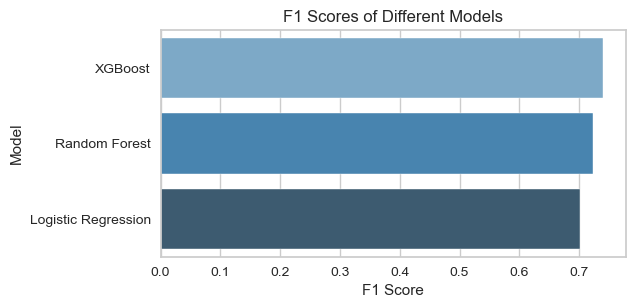

In [61]:
compare = pd.DataFrame({"Model": [ "Random Forest", "XGBoost","Logistic Regression"],
                        "F1 Score": [rfc_f1_score, xgb_f1_score, log_f1_score]})
 
compare = compare.sort_values(by="F1 Score", ascending=False)

plt.figure(figsize=(6,3))
ax = sns.barplot(x="F1 Score", y="Model", data=compare, palette="Blues_d")

plt.yticks(size = 10)
plt.xticks(size = 10)
plt.title("F1 Scores of Different Models", size=12);